# Toegepaste Machine Learning

## Practical Assignment 3

### Important Notes:
1. Submit through **Canvas** in electronic form before 11:59pm on Tuesday, May 31, 2022
2. No late homework will be accepted.
3. This is a group-of-two assignment
4. The submitted file should be in ipynb format
5. The assignment is worth it 10 points
6. **Please make sure you are in a group on canvas!**
7. Question can be asked on the discussion tab on canvas.
8. The indication **optional** means that the question is optional; you won't lose any points if you do not do that part of the assignment, nor will you gain if you do it.

### Software:
We will be using Python programming language throughout this course. Further we will be using:
+ IPython Notebooks (as an environment)
+ Numpy
+ Pandas
+ Scikit-learn


### Background:

This practical assignment will be covering clustering and working with text. 

For the assignment, please download the dataset on [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing), or simply execute the command below. 

The folder contains a number of files, of which you will be using two: plot_summaries.txt and movie.metadata.tsv. Both are tab separated files. The former, i.e. plot_summaries.txt, contains the plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary. The latter file, i.e. movie.metadata.tsv contains metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Freebase is a knowledge base (similar to a database) that contains information about different Entities (including movies). The file is tab-separated with the following columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

The goal of this assignment will be to cluster movies.

**Important Note**: This third assignment is not as instructive as the first assignment. The first assignment guided you step-by-step through all the preprocessing, training-validation-testing setup, etc. This assignment does not do so, but it leaves it up to you to decide how to use the data and design your experiments.

In [15]:
! mkdir MovieSummaries

! gdown "https://drive.google.com/uc?id=1tyun9bJq63hu9A9p11B75HjMQTCG5JpP" -O ./MovieSummaries/movie.metadata.tsv
! gdown "https://drive.google.com/uc?id=1Aeo9WwaKX39Z2zV374zLXW-ndlzcWYDn" -O ./MovieSummaries/moviesrep.csv
! gdown "https://drive.google.com/uc?id=1AnELzvfDWc6NAyV55lfrcVpAoIWzZAAl" -O ./MovieSummaries/plot_summaries.txt
! gdown "https://drive.google.com/uc?id=1CxsqcbtYzAR8S3zLSsstgC6QQa1mUPqd" -O ./MovieSummaries/README.txt

mkdir: MovieSummaries: File exists
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown


### Part 1: Import the data

We import both files and performing a join (merging the two files) using the Wikipedia ID (WID) to match the movies that appear in summaries to those that appear in the metadata. If a movie does not appear in either file, it is not included in the final list.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
metadata = pd.read_csv('movie.metadata.tsv',sep="\t", header = None,
                        names=['WID', 'FID', 'Name', 'Release', 'Revenue', 
                               'Runtime', 'Languages', 'Countries', 'Genres'])
summaries = pd.read_csv('plot_summaries.txt',sep="\t", header = None,
                         names=['WID', 'Text'])
films = pd.merge(metadata, summaries, on='WID')

A movie may have more than one genre. We extract the first genre that characterizes the movie. Some movies may not have any corresponing genres.

In [17]:
import ast

genres = []
for film in films.values:
    exist = False
    g = ast.literal_eval(film[8])
    # Get the first genre for this movie
    for key in g:
        exist = True
        genres.append(g[key])
        break
    # If there is no genre for this movie
    if exist is False:
        genres.append('')

Consider only movies in four genres: 'Drama', 'Comedy', 'Science Fiction', 'Action'. Then sort them by Revenue they had in the cinemas, and get the top 150 most popular ones.

In [18]:
# Merge the films with the genre into a single Dataframe
genres = pd.Series(genres, name='Genre')
films_genre = pd.concat([films, genres], axis=1)

# Get only movies about the four following genres
films_genre_ind = films_genre.set_index('Genre')
movie_genres = ['Drama', 'Comedy', 'Science Fiction', 'Action']
genre150 = pd.DataFrame()
for mg in movie_genres:
    genre150 = genre150.append(films_genre_ind.loc[mg])

# Get the top-150 of those
top150 = (genre150.sort_values(by='Revenue',ascending=False)[0:150]).reset_index()[['Name','Text','Genre']]


What you are left with are 150 movies.

In [50]:
# Show the dataframe of the top150 dataset you will be working on.
top150

,Name,Text,Genre
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction
...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action


In [20]:
# Look at the distribution of your movies in the dataset
print(top150['Genre'].value_counts())

Science Fiction    76
Drama              47
Comedy             18
Action              9
Name: Genre, dtype: int64


### Part 2: Turn movies into BoW representation (Lecture 7) (5pts)

Turn each movie plot summary (i.e. the 'Text' column in the top150 dataframe) into:

* **Bag-of-Words**

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.simplefilter("ignore")

In [22]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(top150.Text)
bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
bow.head()

,000,00am,02,03,04,09,10,100,1000,10__pokemon__a_catchy_toon_crea,...,zoo,zoos,zorgon,zorgons,zubat,zuko,zuul,ángel,über,ōzaru
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **Bag-of-bigrams**

In [23]:

vectorizer = CountVectorizer(stop_words='english',ngram_range=(2,2))
X = vectorizer.fit_transform(top150.Text)
bo2g = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
bo2g.head()

,000 000,000 aaron,000 earlier,000 inheritance,000 irs,000 nbsp,000 organize,000 stars,000 words,000 years,...,ángel track,ángel tries,ángel wants,ángel wears,über morlock,über morlocks,ōzaru having,ōzaru return,ōzaru roshi,ōzaru seven
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **Bag-of-ngrams (for n = 1 and 2)**

In [24]:

vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2))
X = vectorizer.fit_transform(top150.Text)
bo2g = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
bo2g.head()

,000,000 000,000 aaron,000 earlier,000 inheritance,000 irs,000 nbsp,000 organize,000 stars,000 words,...,ángel wants,ángel wears,über,über morlock,über morlocks,ōzaru,ōzaru having,ōzaru return,ōzaru roshi,ōzaru seven
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **TF-IDF values**

In [25]:
count_vect = CountVectorizer()
tf_count = count_vect.fit_transform(top150.Text)
tf_count.shape

(150, 11365)

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tf = tfidf_transformer.fit_transform(tf_count)
tf_idf = pd.DataFrame(tf.toarray(), columns =tfidf_transformer.get_feature_names_out())
tf_idf.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11355,x11356,x11357,x11358,x11359,x11360,x11361,x11362,x11363,x11364
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.023805,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Part 3: Clustering (Lecture 6) (5pts)

Cluster the movies using the k-means algorithm.

**Important Note**: In order to allow you to work on Part 3, before Part 2, the [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing) folder also contains a comma-separated file, moviesrep.csv, that includes a representation I built for you from the movies plot summary. Each line corresponds to a vector representation (i.e. a set of features) for each movie and you can apply the clustering algorithm on this.

**k-means**

+ Choose the number of clusters you wish to find in the data (n_clusters)
+ Take Bag-of-words and TF-IDF representations from Part 2
+ Run a k-means algorithm
+ Evaluate the quality of the algorithm using inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score
    + some of these metrics require the use of ground truth
    + use the genre of each movie as ground truth, i.e. the perfect clustering would be the one that clusters movies based on their genre

**Number of cluster**

* Change the value of n\_clusters and plot inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score as a function of n_clusters
* Explain what you observe in the plots.
* Do the same for each text representation from Part 2.
* Explain the differences across different representations if there are any

Text(0.5, 1.0, 'Elbow Method For Optimal k')

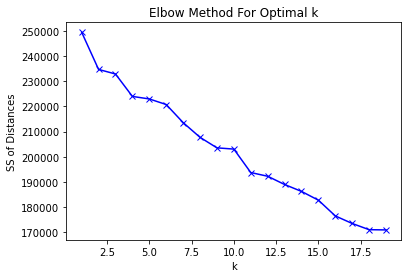

In [27]:
# Inertia
#Finding Best k using Elbow Method 

#Data = Bag of words
from sklearn.cluster import KMeans
SS_distances= []
I = range(1,20)
for i in I:
       k_means = KMeans(n_clusters=i)
       k_means= k_means.fit(bow)
       SS_distances.append(k_means.inertia_)
   


centers = k_means.cluster_centers_

# plotting SSE distances (for each point to the nearest Center) versus number of k 
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SS of Distances')
plt.title('Elbow Method For Optimal k')

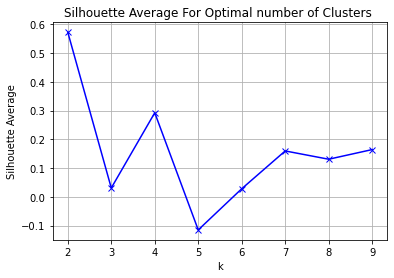

In [38]:
## Silhouette Score


SS_distances= []
I = range(2,10)
for i in I:
       HC = KMeans(n_clusters=i)
       HC= HC.fit(bow)
       score_H= metrics.silhouette_score(bow, HC.labels_)
       SS_distances.append(score_H)

# plotting Silhouette for different clusters
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Average For Optimal number of Clusters ')    
plt.grid()


### Converting Genre into Ground truth i.e. Converting Categorical data in to numeric

In [67]:
Genre_labels = pd.factorize(top150.Genre)[0]
Genre_labels

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 3, 0,
       0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 3, 1, 3, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1,
       0, 1, 0, 0, 2, 2, 0, 1, 3, 0, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 2,
       0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1])

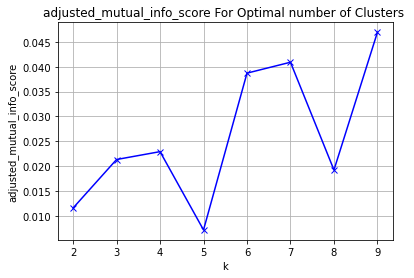

In [77]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
##silhouette_score
from sklearn import metrics

amis= []
I = range(2,10)
for i in I:
       KM2 = KMeans(n_clusters=i)
       KM2= KM2.fit(bow)
       score_KM2= metrics.adjusted_mutual_info_score(Genre_labels,KM2.labels_)
       amis.append(score_KM2)

# plotting adjusted_mutual_info_score for different clusters
plt.plot(I, amis, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_mutual_info_score')
plt.title('adjusted_mutual_info_score For Optimal number of Clusters ')    
plt.grid()


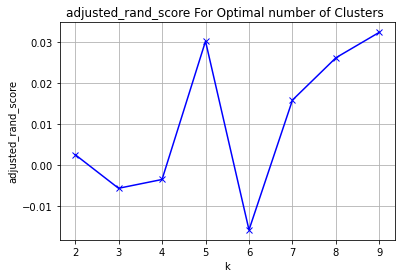

In [79]:
from sklearn.metrics.cluster import adjusted_rand_score
## Adjusted rand Score

ars= []
I = range(2,10)
for i in I:
       KM3 = KMeans(n_clusters=i)
       KM3= KM3.fit(bow)
       score_KM3= metrics.adjusted_rand_score(Genre_labels,KM3.labels_)
       ars.append(score_KM3)

# plotting adjusted_rand_score for different clusters
plt.plot(I, ars, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')
plt.title('adjusted_rand_score For Optimal number of Clusters ')    
plt.grid()


Optimal number of clusters based on silhouette_score is 2.

**Demonstrate clusters**

* for each representation choose the optimal number of clusters and repeat the k-means algorithm for that number of clusters
* print the top-10 most important words within each cluster
* print the titles of the movies for each cluster
* explain what you observe and whether results make sense

In [ ]:
# your code goes here

*your explanations go here*